In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import numba as nb
import charges as charges
import plotting as plotting
from itertools import combinations

In [2]:
high_temp = 50
low_temp = 0.1
steps = 100
linear = np.linspace(high_temp, low_temp, steps)

In [3]:
geometric = np.geomspace(high_temp,low_temp,steps)

In [4]:
# exponential = np.logspace(-9,0,steps, base=2)
diff = high_temp/steps
print(diff)

0.5


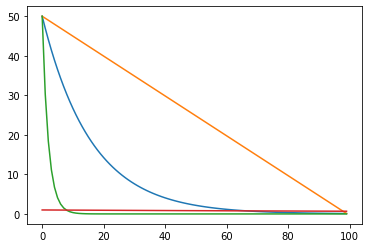

In [5]:
x = np.linspace(low_temp,high_temp,steps)
plt.figure()
plt.plot(geometric)
plt.plot(linear)
# plt.scatter(x,0.001**x, marker=2)
plt.plot([high_temp * np.exp(-diff*x) for x in range(steps)])
plt.plot(high_temp ** (np.array(range(steps))*-0.001))
plt.show()

In [6]:
# np.exp(np.arange(low_temp, high_temp)*-0.001) * high_temp

In [7]:
# [high_temp * np.exp(-0.001*x) for x in range(steps)]

In [8]:
# [high_temp * np.exp(-0.001*x) for x in range(steps)]

In [9]:
# plt.plot([high_temp * np.exp(-0.001*x) for x in range(10000)])

In [10]:
p1 = np.array([1,1])
p2 = np.array([2,2])
delta_x = np.abs(p1[0] - p2[0])
delta_y = np.abs(p1[1] - p2[1])
opp_angle = math.radians(90-math.degrees(math.atan(delta_y/delta_x)))
opp_x = math.sin(math.radians((opp_angle)))

In [11]:
arr_2d = np.vstack(([1,2,3,4,5],[10,20,30,40,50])).T
arr_2d

array([[ 1, 10],
       [ 2, 20],
       [ 3, 30],
       [ 4, 40],
       [ 5, 50]])

In [12]:
a1, a2 = arr_2d, arr_2d
m1,n1 = a1.shape
m2,n2 = a2.shape
out = np.zeros((m1,m2,n1+n2),dtype=int)
out[:,:,:n1] = a1[:,None,:]
out[:,:,n1:] = a2
out.shape = (m1*m2,-1)
out

array([[ 1, 10,  1, 10],
       [ 1, 10,  2, 20],
       [ 1, 10,  3, 30],
       [ 1, 10,  4, 40],
       [ 1, 10,  5, 50],
       [ 2, 20,  1, 10],
       [ 2, 20,  2, 20],
       [ 2, 20,  3, 30],
       [ 2, 20,  4, 40],
       [ 2, 20,  5, 50],
       [ 3, 30,  1, 10],
       [ 3, 30,  2, 20],
       [ 3, 30,  3, 30],
       [ 3, 30,  4, 40],
       [ 3, 30,  5, 50],
       [ 4, 40,  1, 10],
       [ 4, 40,  2, 20],
       [ 4, 40,  3, 30],
       [ 4, 40,  4, 40],
       [ 4, 40,  5, 50],
       [ 5, 50,  1, 10],
       [ 5, 50,  2, 20],
       [ 5, 50,  3, 30],
       [ 5, 50,  4, 40],
       [ 5, 50,  5, 50]])

In [13]:
particles = arr_2d
def euclidean_vec(combs):
    """ Compute the euclidean distance between two points
    """

    return np.sqrt((combs[:,0]- combs[:,2])**2 + (combs[:,1]- combs[:,3])**2)
    # return np.linalg.norm(p2 - p1)

def evaluate_configuration_fast(particles):
    """No idea if this is acc faster."""

    # generate combinations
    m, n = particles.shape
    comb = np.zeros((m, m, n + n), dtype=float)
    comb[:, :, :n] = particles[:, None, :]
    comb[:, :, n:] = particles
    comb.shape = (m * m, -1) # shape is 4 columns w len(particles) rows
    # now we also get p1 -p1 combinations, but
    # their inter-particle distance is 0, so we can ignore that fact
    d = euclidean_vec(comb)
    return 1/np.sum(d[d != 0])

def euclidean(p1, p2):
    """ Compute the euclidean distance between two points
    """
    return np.linalg.norm(p2 - p1)

def evaluate_configuration(particles):
    """ Calculate the total energy of the current configuration
    """
    total = 0
    for i, j in list(combinations(range(len(particles)), 2)):
        p1, p2 = particles[i], particles[j]
        total += 1 / euclidean(p1, p2)

    return total

In [14]:
print(evaluate_configuration_fast(particles))
print(evaluate_configuration(particles))

0.0024875929755249727
0.6384821970514096


In [15]:
step_size = 0.01
rng = np.random.default_rng(None)
delta = rng.uniform(-step_size, step_size, size = 2)
delta

array([ 0.0004559, -0.0060241])

---------------


In [16]:
import matplotlib.cm as cm

def plot_ez(init_points, res):
    points = res

    theta = np.linspace(0, 2 * np.pi, 150)
    a = 1 * np.cos(theta)
    b = 1 * np.sin(theta)

    fig, ax = plt.subplots(1, figsize = (8,8))
    ax.plot(a, b, color='black')
    # plotpoints = []
    # for p in points:
    colors = list(cm.rainbow(np.linspace(0, 1, len(points))))
    for i in range(len(points)):
        ax.scatter(init_points[i,0], init_points[i,1],color=colors[i])
        ax.scatter(points[i,0], points[i,1],s=100,marker='X',color=colors[i])
    # scatter = ax.scatter(init_points[:,0], init_points[:,1], color='black',label='before')
    # scatter = ax.scatter(points[:,0], points[:,1], color='red',s=100,marker='x', label = 'black')
    plt.title("x is after")
    ax.set_aspect(1)
    # plt.legend()

5.9559861884387315
11.503631822264586
11.707480855882233
11.114548732337964
10.770996295718623
10.529718672312045
10.346587038284685
10.258184926764288
10.68322112031256
10.268936718156462
10.489953018522108
10.081526841028916
10.204185097259087
10.112664451874078
9.928376019105604
9.76772221684396
10.121391637873108
10.329884170539126
9.903482599001201
9.984980647026584
10.156529184292468
10.224226122100287
10.14899834374651
10.285260185807454
10.724489974126953
10.976769835622171
11.27278276311832
11.57054394718372
11.689953318166657
11.318056249256077
11.291868830818832
11.04757375058093
10.838403749707396
10.828020751624697
10.461267854301092
10.959674266646855
10.979864701649822
11.278849073879817
11.603380208903419
11.481826492426872
11.86453562172328
11.775248729026274
11.336244653639953
11.479068009645248
11.526218661346093
11.14836013194209
11.064829313715666
10.770440016361697
10.428821721294312
10.375675626412198
10.101066613700596
9.831973068715921
10.172143027043331
10.200

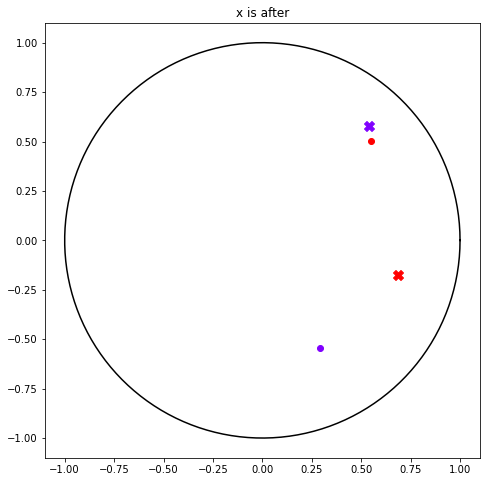

In [17]:


my_charge = charges.Charges(2,1)
init_points = my_charge.generate_points(2)
# print(init_points)
# my_charge.evaluate_configuration()
# my_charge.evaluate_configuration_fast() # does not work, div by 0
colors = cm.rainbow(np.linspace(0, 1, len(init_points)))
res = my_charge.iterate_SA_optimize(0.001,50,24_000,'linear', False)
plot_ez(init_points,res)
# evaluate_configuration_fast(res)

# m, n = res.shape
# comb = np.zeros((m, m, n + n), dtype=float)
# comb[:, :, :n] = res[:, None, :]
# comb[:, :, n:] = res
# comb.shape = (m * m, -1) # shape is 4 columns w len(particles) rows
# print(comb)
# # now we also get p1 -p1 combinations, but
# # their inter-particle distance is 0, so we can ignore that fact
#
# 1/np.sum(euclidean_vec(comb))


In [18]:
print(evaluate_configuration_fast(init_points))
print(evaluate_configuration_fast(res))

0.46242284857165933
0.6483675545357476


In [19]:
m, n = particles.shape
comb = np.zeros((m, m, n + n), dtype=int)
comb[:, :, :n] = particles[:, None, :]
comb[:, :, n:] = particles
comb.shape = (m * m, -1)

In [20]:
combs = comb

In [21]:
np.sqrt((combs[:,0]- combs[:,2])**2 + (combs[:,1]- combs[:,3])**2)

array([ 0.        , 10.04987562, 20.09975124, 30.14962686, 40.19950248,
       10.04987562,  0.        , 10.04987562, 20.09975124, 30.14962686,
       20.09975124, 10.04987562,  0.        , 10.04987562, 20.09975124,
       30.14962686, 20.09975124, 10.04987562,  0.        , 10.04987562,
       40.19950248, 30.14962686, 20.09975124, 10.04987562,  0.        ])

In [22]:
import pandas as pd

In [23]:
# data = pd.read_csv('logged_data/2_linear_30000.csv', sep=',')

In [24]:
my_data = np.loadtxt('logged_data/2_linear_24000.csv', delimiter=',',skiprows=1)

In [25]:
my_data

array([ 5.95598619, 11.50363182, 11.70748086, ...,  2.64990732,
        2.64990732,  2.62562683])

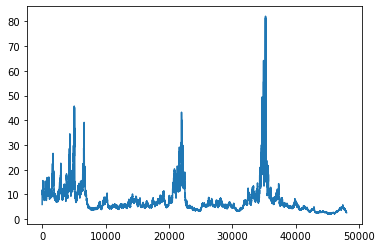

In [26]:
plt.plot(my_data)